## Final Project: Forecast Bacteria using KNN Classification, Linear Logistic Regression, Decision Tree/Bagged Decision Trees, and Random Forest

## Load and Clean the Data Set

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model, metrics, cross_validation, grid_search, neighbors

import seaborn as sns
sns.set(style="whitegrid", font_scale=1)
%matplotlib inline

In [19]:
#1 Load Data
bdf = pd.read_excel('./BacteriaData2011-2016D.xlsx')

bdf.head()

,LOT_NUMBER,MATERIAL_CODE,PROTOCOL_NAME,SAMPLE_DESC,SAMPLE_COLLECTION_DATE,COMPONENT,Organism_Name,Total_Count,UNITS
0,LA11A054,5% ALBUMIN IP,MOTHER,DF,2011-03-03 16:57:27,Organism Name,NaN,Unattainable,Genus Species
1,LA11E002,25% ALBUMIN IP,SUSP TARGET 6.5,SU,2011-01-02 00:26:17,Total Count/mL,None,0,CFU/mL
2,LA11E001,25% ALBUMIN IP,SUSP TARGET 6.5,SU,2011-01-02 04:56:46,Total Count/mL,None,0,CFU/mL
3,LA11M001,AHF-M IP,BIO SINGLE SUSP,A SUSP I,2011-01-03 01:50:19,Total Count/mL,Unattainable,49.6,CFU/mL
4,LA11M001,AHF-M IP,BIO SINGLE SUSP,C SUSP I,2011-01-03 09:42:26,Total Count/mL,Unattainable,4.8,CFU/mL


In [13]:
bdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17740 entries, 0 to 17739
Data columns (total 9 columns):
LOT_NUMBER                17740 non-null object
MATERIAL_CODE             17740 non-null object
PROTOCOL_NAME             17740 non-null object
SAMPLE_DESC               17740 non-null object
SAMPLE_COLLECTION_DATE    17740 non-null datetime64[ns]
COMPONENT                 17740 non-null object
Organism_Name             17739 non-null object
Total_Count               17658 non-null object
UNITS                     17740 non-null object
dtypes: datetime64[ns](1), object(8)
memory usage: 1.2+ MB


In [20]:
#2 Pre-process Data
# check for missing values
print "Missing values:"
print bdf.isnull().sum()
# drop missing values
if bdf.isnull().sum().sum():
    bdf = bdf.dropna()

Missing values:
LOT_NUMBER                 0
MATERIAL_CODE              0
PROTOCOL_NAME              0
SAMPLE_DESC                0
SAMPLE_COLLECTION_DATE     0
COMPONENT                  0
Organism_Name              1
Total_Count               82
UNITS                      0
dtype: int64


In [21]:
# Reset index after drop
bdf.sort_values('SAMPLE_COLLECTION_DATE', inplace=True)
bdf.reset_index(drop=True, inplace=True)
bdf

,LOT_NUMBER,MATERIAL_CODE,PROTOCOL_NAME,SAMPLE_DESC,SAMPLE_COLLECTION_DATE,COMPONENT,Organism_Name,Total_Count,UNITS
0,LA11E002,25% ALBUMIN IP,SUSP TARGET 6.5,SU,2011-01-02 00:26:17,Total Count/mL,None,0,CFU/mL
1,LA11E001,25% ALBUMIN IP,SUSP TARGET 6.5,SU,2011-01-02 04:56:46,Total Count/mL,None,0,CFU/mL
2,LA11M001,AHF-M IP,BIO SINGLE SUSP,A SUSP I,2011-01-03 01:50:19,Total Count/mL,Unattainable,49.6,CFU/mL
3,LA11M001,AHF-M IP,BIO SINGLE SUSP,C SUSP I,2011-01-03 09:42:26,Total Count/mL,Unattainable,4.8,CFU/mL
4,LA11E003,25% ALBUMIN IP,SUSP TARGET 6.5,SU,2011-01-03 15:30:22,Total Count/mL,None,0,CFU/mL
5,LA11E002,25% ALBUMIN IP,SUSP TARGET 6.5,CN,2011-01-03 16:55:17,Total Count/mL,None,0,CFU/mL
6,LA11E004,25% ALBUMIN IP,SUSP TARGET 6.5,SU,2011-01-03 18:06:45,Total Count/mL,None,0,CFU/mL
7,LA11E001,25% ALBUMIN IP,SUSP TARGET 6.5,CN,2011-01-03 19:33:06,Total Count/mL,None,0,CFU/mL
8,LA11N201,AHF-M IP,ARC SINGLE SUSP 2 CL,A SUSP I,2011-01-04 14:41:15,Total Count/mL,Microbacterium/Serratia,294.4,CFU/mL
9,LA11D005,25% ALBUMIN IP,SUPERBULK TARGET 8.5,SU,2011-01-05 11:03:19,Total Count/mL,None,0,CFU/mL


In [22]:
# Change Total Count to the right data type
bdf['Total_Count']=bdf['Total_Count'].astype(float)
print bdf.dtypes

LOT_NUMBER                        object
MATERIAL_CODE                     object
PROTOCOL_NAME                     object
SAMPLE_DESC                       object
SAMPLE_COLLECTION_DATE    datetime64[ns]
COMPONENT                         object
Organism_Name                     object
Total_Count                      float64
UNITS                             object
dtype: object


In [24]:
# Feature Engineering, adding a column that counts different bacteria species
print bdf['Organism_Name'].head(10)
bdf['Organism_Count'] = bdf['Organism_Name'].map(lambda x: len(x.split('/')))
print bdf['Organism_Count'].head(10)

0                       None
1                       None
2               Unattainable
3               Unattainable
4                       None
5                       None
6                       None
7                       None
8    Microbacterium/Serratia
9                       None
Name: Organism_Name, dtype: object
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    2
9    1
Name: Organism_Count, dtype: int64


In [25]:
# add DOW & DOM
bdf['Week Day'] = bdf['SAMPLE_COLLECTION_DATE'].dt.dayofweek.map({0:'Mon', 1:'Tues', 2:'Wed', 3:'Thurs', 4:'Fri', 5:'Sat', 6:'Sun'})
bdf['Month'] = bdf['SAMPLE_COLLECTION_DATE'].map(lambda x: x.month)
bdf['Month'] = bdf['Month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',7:'Jul',\
8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
bdf.head()

,LOT_NUMBER,MATERIAL_CODE,PROTOCOL_NAME,SAMPLE_DESC,SAMPLE_COLLECTION_DATE,COMPONENT,Organism_Name,Total_Count,UNITS,Organism_Count,Week Day,Month
0,LA11E002,25% ALBUMIN IP,SUSP TARGET 6.5,SU,2011-01-02 00:26:17,Total Count/mL,None,0.0,CFU/mL,1,Sun,Jan
1,LA11E001,25% ALBUMIN IP,SUSP TARGET 6.5,SU,2011-01-02 04:56:46,Total Count/mL,None,0.0,CFU/mL,1,Sun,Jan
2,LA11M001,AHF-M IP,BIO SINGLE SUSP,A SUSP I,2011-01-03 01:50:19,Total Count/mL,Unattainable,49.6,CFU/mL,1,Mon,Jan
3,LA11M001,AHF-M IP,BIO SINGLE SUSP,C SUSP I,2011-01-03 09:42:26,Total Count/mL,Unattainable,4.8,CFU/mL,1,Mon,Jan
4,LA11E003,25% ALBUMIN IP,SUSP TARGET 6.5,SU,2011-01-03 15:30:22,Total Count/mL,None,0.0,CFU/mL,1,Mon,Jan


In [27]:
# Add a target column called Contaminated 
# Compute the weighted sum for the contamination threshhold
SDAMean = bdf[bdf.COMPONENT == 'SDA-Total Count/mL'].Total_Count.mean()
TSAMean = bdf[bdf.COMPONENT == 'TSA-Total Count/mL'].Total_Count.mean()
TotalMean = bdf[bdf.COMPONENT == 'Total Count/mL'].Total_Count.mean()
#print SDAMean, TSAMean, TotalMean
#Set up the weights, TotalMean
w1=0.1
w2=0.3
w3=0.6
wmean=w1*SDAMean + w2*TSAMean + w3*TotalMean
print wmean

bdf['Contaminated'] = bdf['Total_Count'].map(lambda x: 1 if x >= wmean else 0)
bdf['Contaminated'].head()

4.88838576822


0    0
1    0
2    1
3    0
4    0
Name: Contaminated, dtype: int64

## Exploratory Data Analysis

In [28]:
#Descriptive Statistics for numerical fields 
bdf.describe()

,Total_Count,Organism_Count,Contaminated
count,17657.000000,17657.000000,17657.000000
mean,1.523113,1.017500,0.041173
std,13.866624,0.199057,0.198697
min,0.000000,1.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,1.000000,0.000000
75%,0.000000,1.000000,0.000000
max,464.800000,6.000000,1.000000


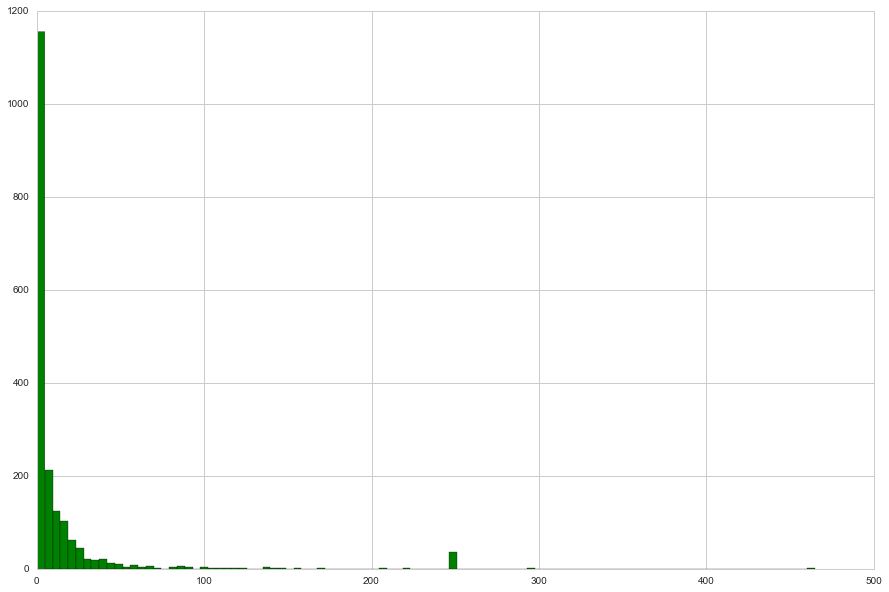

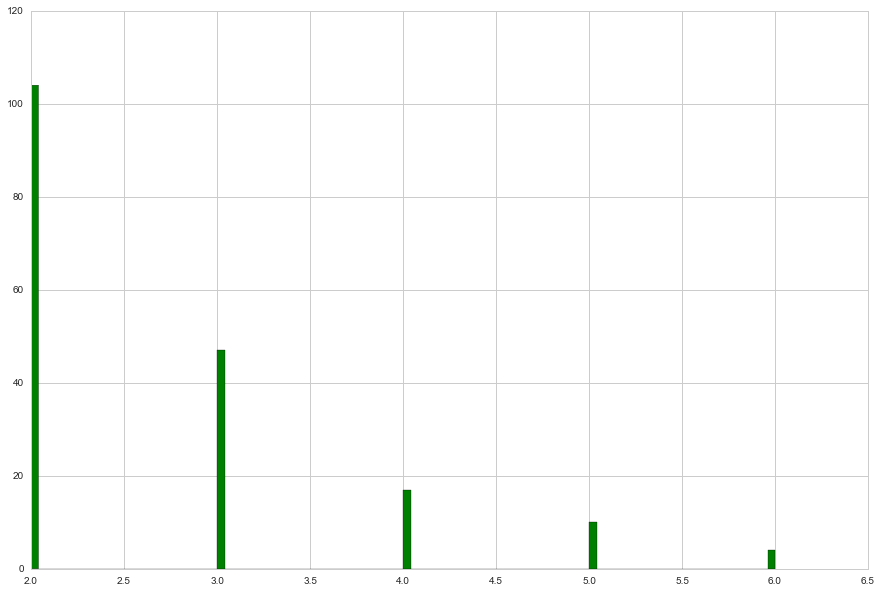

In [29]:
# Detect the outliers
#bdf['Total_Count'].hist(figsize=(20,15), bins=100, color='g')
bdf[bdf['Total_Count']>0]['Total_Count'].hist(figsize=(15,10), bins=100, color='g')
fig=plt.figure()
#bdf['Organism_Count'].hist(figsize=(20,15), bins=100, color='g')
bdf[bdf['Organism_Count']>1]['Organism_Count'].hist(figsize=(15,10), bins=100, color='g')

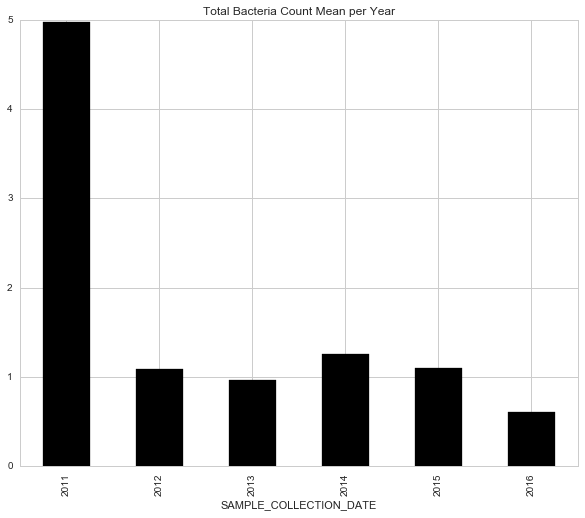

In [30]:
# average total count per year
bdf.groupby(bdf['SAMPLE_COLLECTION_DATE'].dt.year)['Total_Count']\
.mean().plot(kind='bar', figsize=(10,8), color='k', title='Total Bacteria Count Mean per Year')
#bdf[bdf['Total_Count']>1].groupby(bdf['SAMPLE_COLLECTION_DATE'].dt.year)['Total_Count']\
#.mean().plot(kind='bar', figsize=(10,8), color='k', title='Toal Bacteria Count Mean per Year')

(0, 50)

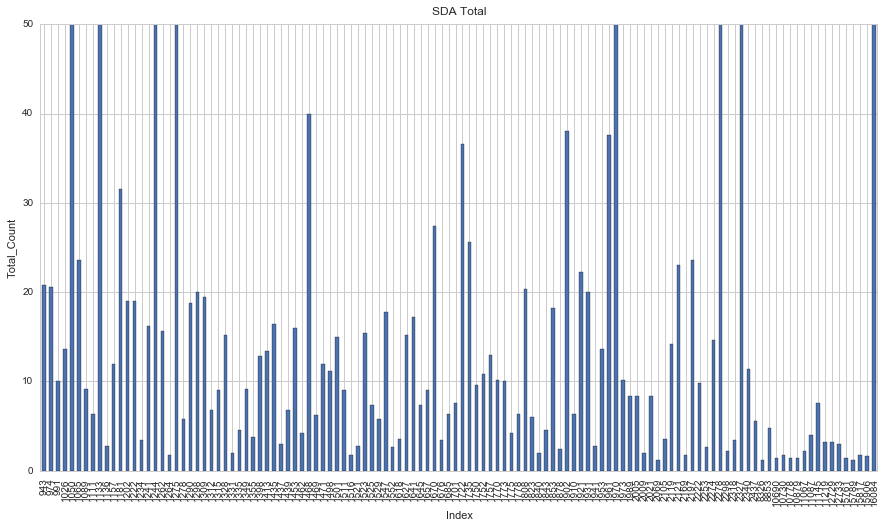

In [31]:
# SDA Total Count
fig, ax = plt.subplots(figsize=(15,8))
#bdf[bdf.COMPONENT == 'SDA-Total Count/mL']['Total_Count'].plot(kind='bar')
bdf[(bdf.COMPONENT == 'SDA-Total Count/mL') & (bdf['Total_Count']>1)]['Total_Count'].plot(kind='bar')
ax.set_title('SDA Total', y=1.01)
ax.set_ylabel('Total_Count')
ax.set_xlabel('Index')
ax.set_ylim(0,50)

(0, 50)

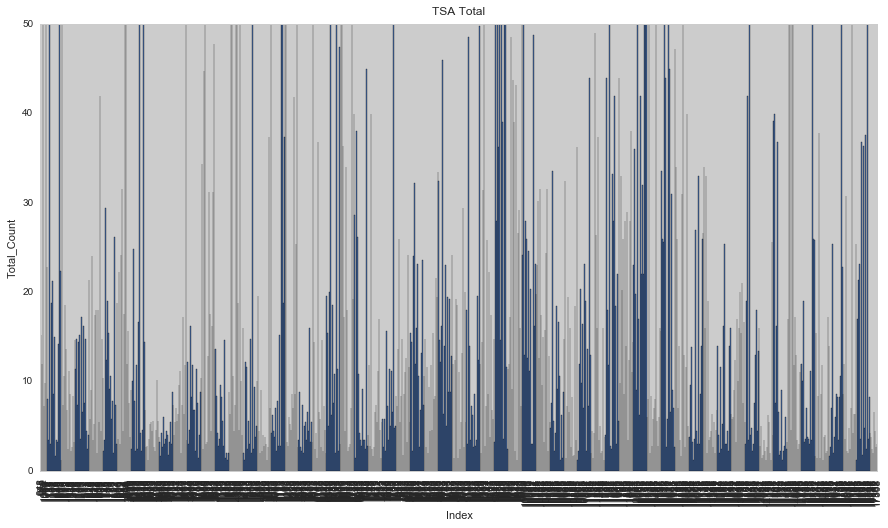

In [32]:
# TSA Total Count
fig, ax = plt.subplots(figsize=(15,8))
#bdf[bdf.COMPONENT == 'TSA-Total Count/mL']['Total_Count'].plot(kind='bar')
bdf[(bdf.COMPONENT == 'TSA-Total Count/mL')&(bdf['Total_Count']>1)]['Total_Count'].plot(kind='bar')
ax.set_title('TSA Total', y=1.01)
ax.set_ylabel('Total_Count')
ax.set_xlabel('Index')
ax.set_ylim(0,50)

(0, 50)

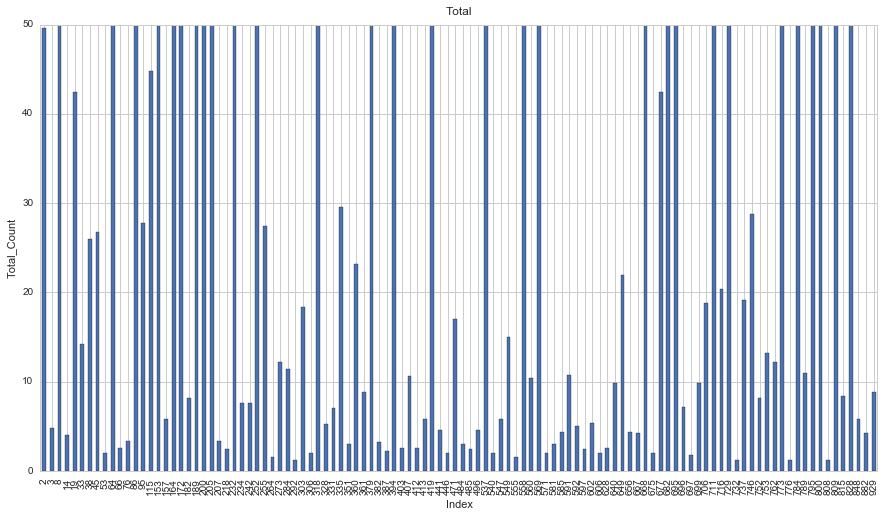

In [33]:
# Total Total Count
fig, ax = plt.subplots(figsize=(15,8))
#bdf[bdf.COMPONENT == 'Total Count/mL']['Total_Count'].plot(kind='bar')
bdf[(bdf.COMPONENT == 'Total Count/mL')&(bdf['Total_Count']>1)]['Total_Count'].plot(kind='bar')
ax.set_title('Total', y=1.01)
ax.set_ylabel('Total_Count')
ax.set_xlabel('Index')
ax.set_ylim(0,50)

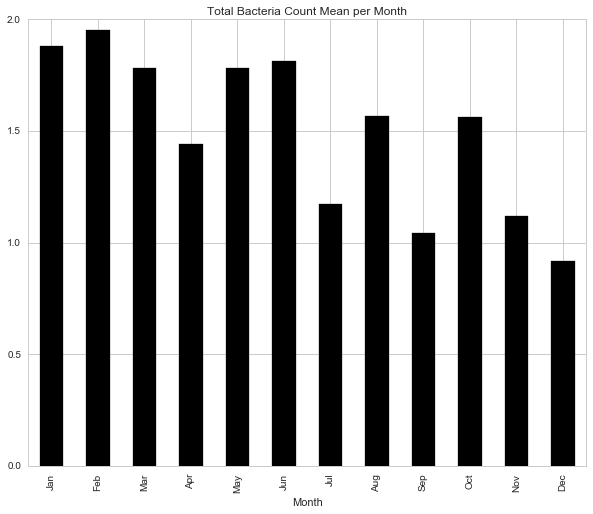

In [34]:
# average total count per month
bdf.groupby(bdf['Month'],sort=False)['Total_Count']\
.mean().plot(kind='bar', figsize=(10,8), color='k', title='Total Bacteria Count Mean per Month')

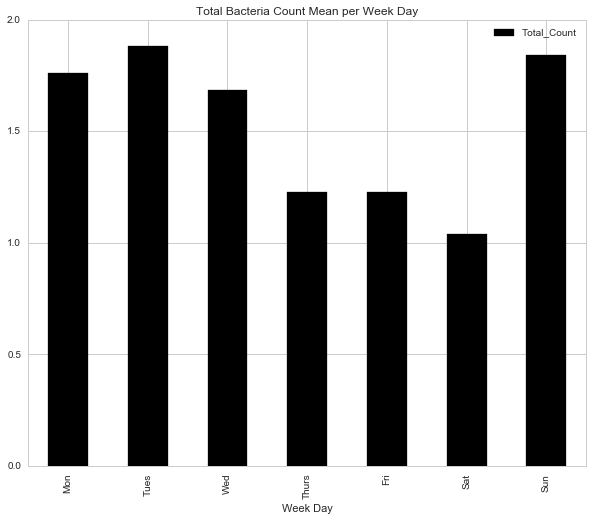

In [36]:
# average total count per day
weekday = pd.DataFrame(bdf.groupby(bdf['Week Day'])['Total_Count'].mean())
weekday=weekday.rename(index={'Mon':0, 'Tues':1, 'Wed':2, 'Thurs':3, 'Fri':4, 'Sat':5, 'Sun':6})
weekday=weekday.sort_index()
weekday=weekday.rename(index={0:'Mon', 1:'Tues', 2:'Wed', 3:'Thurs', 4:'Fri', 5:'Sat', 6:'Sun'})
#weekday
weekday.plot(kind='bar', figsize=(10,8), color='k', title='Total Bacteria Count Mean per Week Day')

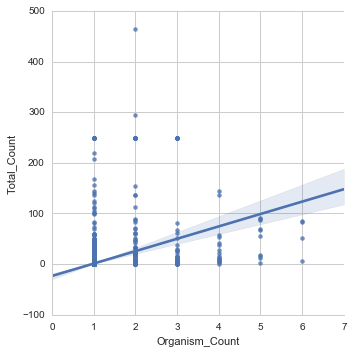

In [18]:
#Check the relation between Organism Count and Total Count
sns.lmplot('Organism_Count', 'Total_Count', bdf)

No linear relationship between the two.

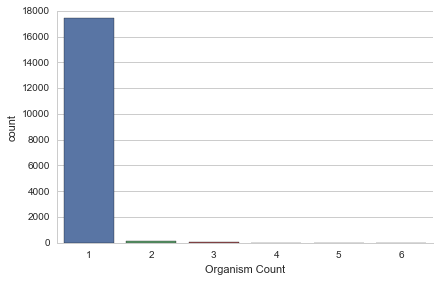

In [37]:
# use seaborn to plot the count of Organism in each Organism_Count
fg = sns.factorplot('Organism_Count', data=bdf, kind='count', aspect=1.5)
fg.set_xlabels('Organism Count')

In [38]:
#Drop the hidden deselected row
bdf = bdf.drop(bdf[bdf.COMPONENT == 'Organism Name'].index)

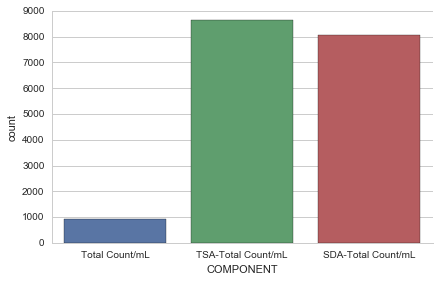

In [39]:
# use seaborn to plot the count of COMPONENT in each type of COMPONENT
fg = sns.factorplot('COMPONENT', data=bdf, kind='count', aspect=1.5)
fg.set_xlabels('COMPONENT')

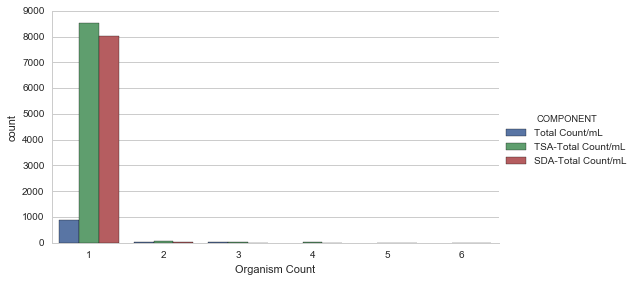

In [23]:
# use seaborn to group by Organism_Count and COMPONENT
g = sns.factorplot('Organism_Count', data=bdf, hue='COMPONENT', kind='count', aspect=1.75)
g.set_xlabels('Organism Count')

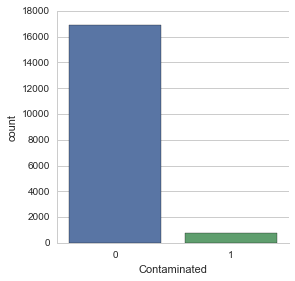

In [24]:
# Factor plot of those bacteria that contaminated vs. those that didn't
sns.factorplot('Contaminated', data=bdf, kind='count')

In [29]:
# those bacteria that contaminated vs. those that didn't grouped by Organism_Count and COMPONENT
table = pd.crosstab(index=[bdf.Contaminated,bdf.Organism_Count], columns=[bdf.COMPONENT])
table.unstack()

COMPONENT      SDA-Total Count/mL                            \
Organism_Count                  1     2    3    4    5    6   
Contaminated                                                  
0                          7959.0  20.0  4.0  2.0  0.0  NaN   
1                            64.0   5.0  5.0  4.0  1.0  1.0   

COMPONENT      TSA-Total Count/mL                             Total Count/mL  \
Organism_Count                  1     2     3     4    5    6              1   
Contaminated                                                                   
0                          8052.0  15.0   7.0   1.0  1.0  NaN          856.0   
1                           494.0  42.0  16.0  10.0  8.0  3.0           43.0   

COMPONENT                                  
Organism_Count     2     3    4    5    6  
Contaminated                               
0                2.0   4.0  0.0  0.0  NaN  
1               20.0  11.0  0.0  0.0  0.0

### Feature Engineering: Add new info ???

In [30]:
bdf.columns

Index([            u'LOT_NUMBER',          u'MATERIAL_CODE',
                u'PROTOCOL_NAME',            u'SAMPLE_DESC',
       u'SAMPLE_COLLECTION_DATE',              u'COMPONENT',
                u'Organism_Name',            u'Total_Count',
                        u'UNITS',         u'Organism_Count',
                     u'Week Day',                  u'Month',
                 u'Contaminated'],
      dtype='object')

### Set column features for X, y

In [31]:
# Patsy 
from patsy import dmatrix
X = dmatrix('Month + Q("Week Day") + Q("MATERIAL_CODE") + Q("PROTOCOL_NAME") + Q("SAMPLE_DESC") +\
Q("COMPONENT") + Q("Organism_Name") + Q("Organism_Count")', data=bdf, return_type='dataframe')
X

,Intercept,Month[T.Aug],Month[T.Dec],Month[T.Feb],Month[T.Jan],Month[T.Jul],Month[T.Jun],Month[T.Mar],Month[T.May],Month[T.Nov],...,"Q(""Organism_Name"")[T.Serratia/Chryseobacterium]","Q(""Organism_Name"")[T.Serratia/Cryptococcus]","Q(""Organism_Name"")[T.Serratia/Pseudomonas]","Q(""Organism_Name"")[T.Serratia/Stenotrophomonas]","Q(""Organism_Name"")[T.Staphylococcus]","Q(""Organism_Name"")[T.Stenotrophomonas]","Q(""Organism_Name"")[T.Stenotrophomonas/Bacillus]","Q(""Organism_Name"")[T.Stenotrophomonas/Unattainable]","Q(""Organism_Name"")[T.Unattainable]","Q(""Organism_Count"")"
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [40]:
# select columns for y
y = bdf['Contaminated']

## 1. Binary classification using KNN Classifier (K-nearest neighbors)

In [33]:
#Split the data into trainning and testing using Cross Validation
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=1)

knn = neighbors.KNeighborsClassifier(n_neighbors=50, weights='uniform')
knn.fit(X_train, y_train)

# Evaluate accuracy of model on date set
print "Accuracy: %0.3f" % knn.score(X_test, y_test)

Accuracy: 0.982


ROC AUC: 0.987


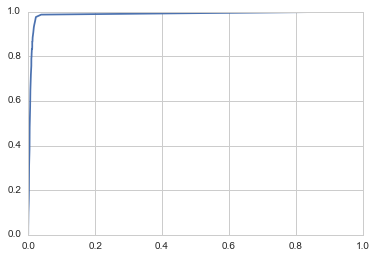

In [34]:
# Plot ROC curve and Evaluate ROC AUC score of model on date set
from sklearn.metrics import roc_curve, roc_auc_score

probas = knn.predict_proba(X_test)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])

print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])

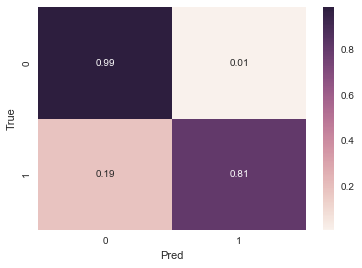

[[8368   87]
 [  69  301]]


In [35]:
# confusion matrix

y_pred = knn.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print cm

In [37]:
# Precision of the model using test data to predict the contamination is 78%
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      8455
          1       0.78      0.81      0.79       370

avg / total       0.98      0.98      0.98      8825



In [56]:
def predicted_vs_actual_df():
    pred_label = knn.predict(X_test)
    results=[]
    for predicted_label, trained_label, idx, chg in zip(pred_label, y_test, y_test.index, bdf.ix[y_test.index]['Total_Count']):
        if predicted_label == trained_label:
            results.append([idx, chg, predicted_label, trained_label, 1])
        else:
            results.append([idx, chg, predicted_label, trained_label, 0])
    return pd.DataFrame(results, columns=['index', 'Total_Count', 'predicted', 'actual', 'correct'])

rf = predicted_vs_actual_df()
rf

,index,Total_Count,predicted,actual,correct
0,16932,0.0,0,0,1
1,2656,0.0,0,0,1
2,16325,0.0,0,0,1
3,3899,0.0,0,0,1
4,15837,0.0,0,0,1
5,12135,0.0,0,0,1
6,5131,0.0,0,0,1
7,14839,0.0,0,0,1
8,12150,0.0,0,0,1
9,6895,0.0,0,0,1


In [40]:
#Base line
rf[rf['actual']==1]['Total_Count'].describe()

count    370.000000
mean      35.892973
std       59.418415
min        5.000000
25%        8.650000
50%       14.800000
75%       28.000000
max      249.800000
Name: Total_Count, dtype: float64

In [41]:
#Predicted
rf[rf['predicted']==1]['Total_Count'].describe()

count    388.000000
mean      24.763402
std       46.517176
min        2.000000
25%        5.400000
50%       11.600000
75%       20.450000
max      249.800000
Name: Total_Count, dtype: float64

##### Predicted 301 contaminations correctly and 69 incorrectly, so total is 370
(There are total 301+69=370 contaminations, 301 predicted correctly, so the accuracy is 301/370=81%)

## 2. Binary classification using logistic regression

### Search best C for the Logictic Regression
C is the inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
Regularization is an additive approach to protect models against overfitting (being potentially biased and overconfident, not generalizing well).

Regularization becomes an additional weight to coefficients, shrinking
them closer to zero.
(The following code is from Lession 9 DS-DC-13)

LogisticRegressionCV(Cs=3, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)


(0, 15)

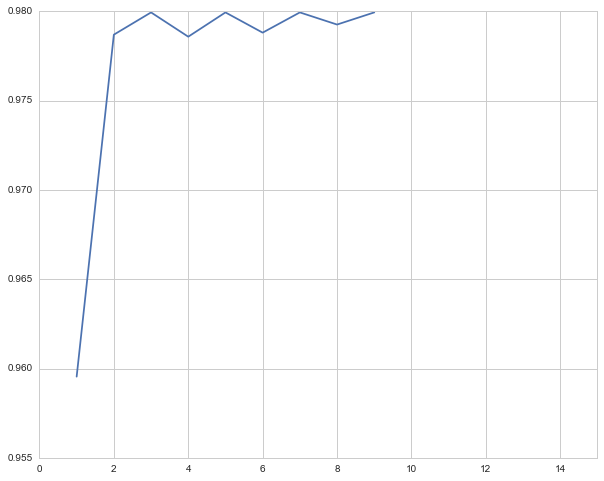

In [43]:
# Find the best regularization parameter Cs for the Linear LogisticRegressionCV (cross-validation generator) Model 
# using Grid Search
from sklearn import grid_search

# set list of values to grid search over
c = range(1, 10)
params = {'Cs': c}

# perform grid search using list of values
gs = grid_search.GridSearchCV(
    estimator=linear_model.LogisticRegressionCV(),
    param_grid=params)
gs.fit(X_train, y_train)

# get best value to use
print gs.best_estimator_

# plot search values vs. grid scores
plt.figure(figsize=(10,8))
plt.plot(c, [s[1] for s in gs.grid_scores_])
plt.xlim((0,15))

In [44]:
# Logistic regression using Cs=3
clf = linear_model.LogisticRegressionCV(Cs=3)
clf.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % clf.score(X_test, y_test)
# Evaluate ROC AUC score of model on test set

Accuracy: 0.983


ROC AUC: 0.994


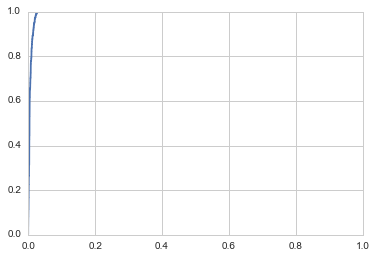

In [45]:
# Plot ROC curve and Evaluate ROC AUC score of model on date set
probas = clf.predict_proba(X_test)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])

print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

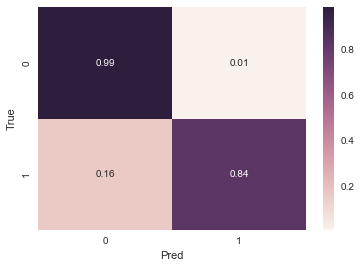

[[8369   86]
 [  61  309]]


In [46]:
# Get confusion matrix on test set
y_pred = clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print cm

In [47]:
# Precision of the model using test data to predict the contamination is 78%
print(metrics.classification_report(y_test, y_pred))

displayCM(cm)

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      8455
          1       0.78      0.84      0.81       370

avg / total       0.98      0.98      0.98      8825

Sensitivity or Recall: 0.835
Specificity: 0.990
The precision: 0.782


Explain ???

In [52]:
#Find out the important features
fv = pd.DataFrame(X_train.columns, clf.coef_.T).reset_index()
fv.columns = ['Coef', 'Feature']
fv.sort_values('Coef', ascending=0).reset_index(drop=True).head()

,Coef,Feature
0,1.934853,"Q(""Organism_Name"")[T.Microbacterium]"
1,1.467836,"Q(""Organism_Name"")[T.Pseudomonas]"
2,1.437520,"Q(""SAMPLE_DESC"")[T.A SUSP I]"
3,1.327106,"Q(""Organism_Name"")[T.Bacillus]"
4,1.203779,"Q(""Organism_Name"")[T.Serratia]"


For categorical features, a positive sign on the feature' coefficient tells us that when present, this feature increases the probability of a positive outcome versus the baseline. For continuous features, a positive sign tells us that an increase in the value of this feature corresponds to an increase in the probability of a positive outcome. The size of the coefficient tells us the magnitude of the increase in probability. Let's examine this by looking at the days of the week:

In [49]:
fv[fv['Feature'].str.contains('Week Day')]

,Coef,Feature
12,0.017326,"Q(""Week Day"")[T.Mon]"
13,0.034175,"Q(""Week Day"")[T.Sat]"
14,0.506380,"Q(""Week Day"")[T.Sun]"
15,-0.274563,"Q(""Week Day"")[T.Thurs]"
16,-0.234865,"Q(""Week Day"")[T.Tues]"
17,0.356532,"Q(""Week Day"")[T.Wed]"


Explain: Tuesday is the worst ???

In [50]:
def predicted_vs_actual_df():
    pred_label = clf.predict(X_test)
    results=[]
    for predicted_label, trained_label, idx, chg in zip(pred_label, y_test, y_test.index, bdf.ix[y_test.index]['Total_Count']):
        if predicted_label == trained_label:
            results.append([idx, chg, predicted_label, trained_label, 1])
        else:
            results.append([idx, chg, predicted_label, trained_label, 0])
    return pd.DataFrame(results, columns=['index', 'Total_Count', 'predicted', 'actual', 'correct'])

rf = predicted_vs_actual_df()
rf

,index,Total_Count,predicted,actual,correct
0,16932,0.0,0,0,1
1,2656,0.0,0,0,1
2,16325,0.0,0,0,1
3,3899,0.0,0,0,1
4,15837,0.0,0,0,1
5,12135,0.0,0,0,1
6,5131,0.0,0,0,1
7,14839,0.0,0,0,1
8,12150,0.0,0,0,1
9,6895,0.0,0,0,1


In [51]:
rf[rf['predicted']==1]['Total_Count'].describe()

count    395.000000
mean      27.871392
std       51.613612
min        0.000000
25%        5.700000
50%       12.400000
75%       23.600000
max      249.800000
Name: Total_Count, dtype: float64

##### Predicted 309 contaminations correctly and 61 incorrectly, so total is 370
(There are total 309+61=370 contaminations, 309 predicted correctly, so the accuracy is 309/370=84%)

### Model evaluation

From Logstic Regression, we can see about 84% of our predictions were accurate. ???

Let's look at a plot of our returns:

(0, 10)

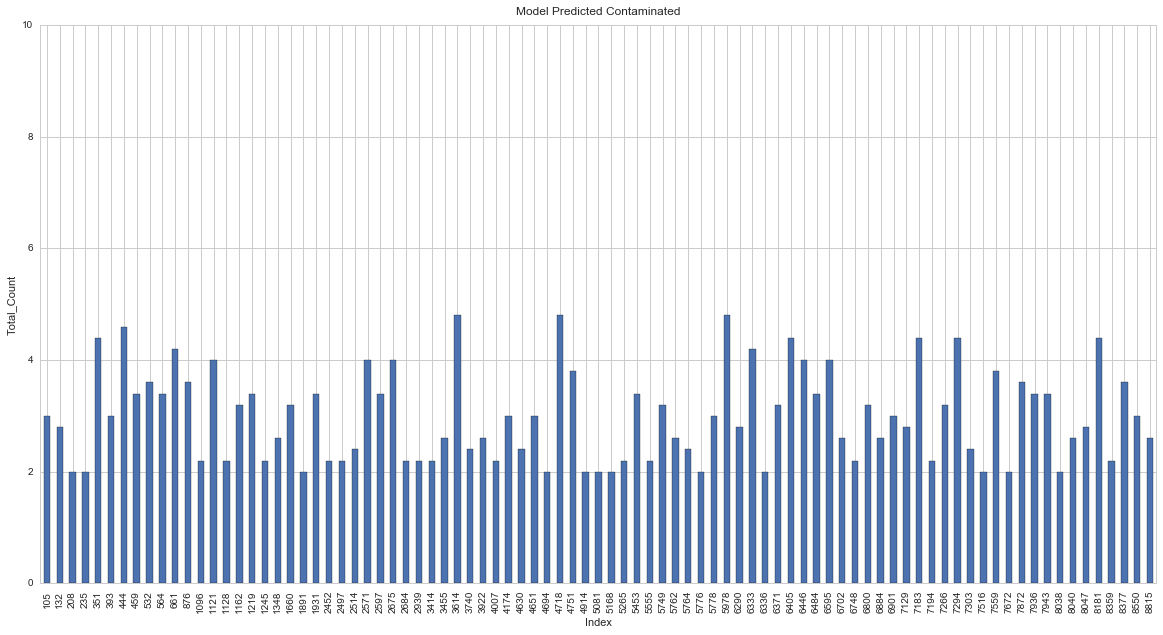

In [57]:
#Plot the wrong prediction
fig, ax = plt.subplots(figsize=(20,10))
rf[(rf['predicted']==1) & (rf['Total_Count']<wmean)]['Total_Count'].plot(kind='bar')
ax.set_title('Model Predicted Contaminated', y=1.01)
ax.set_ylabel('Total_Count')
ax.set_xlabel('Index')
ax.set_ylim(0,10)

Explain (error are spread out ???

In [59]:
#Use the important feature with total count > wmean threshole and 2011 as the training data
bdf[bdf['Organism_Name'].str.contains('Microbacterium')]

,LOT_NUMBER,MATERIAL_CODE,PROTOCOL_NAME,SAMPLE_DESC,SAMPLE_COLLECTION_DATE,COMPONENT,Organism_Name,Total_Count,UNITS,Organism_Count,Week Day,Month,Contaminated
8,LA11N201,AHF-M IP,ARC SINGLE SUSP 2 CL,A SUSP I,2011-01-04 14:41:15,Total Count/mL,Microbacterium/Serratia,294.4,CFU/mL,2,Tues,Jan,1
64,LA11N204,AHF-M IP,ARC SINGLE SUSP 2 CL,A SUSP I,2011-01-17 02:10:33,Total Count/mL,Microbacterium/Serratia,68.8,CFU/mL,2,Mon,Jan,1
153,LA11N207,AHF-M IP,ARC SINGLE SUSP 2 CL,A SUSP I,2011-02-01 21:37:46,Total Count/mL,Microbacterium/Serratia/Sphingobacterium,51.2,CFU/mL,3,Tues,Feb,1
172,LA11N208,AHF-M IP,ARC SINGLE SUSP 2 CL,A SUSP I,2011-02-04 21:46:21,Total Count/mL,Microbacterium/Serratia,51.2,CFU/mL,2,Fri,Feb,1
200,LA11M012,AHF-M IP,BIO SINGLE SUSP,A SUSP I,2011-02-09 16:06:00,Total Count/mL,Microbacterium/Serratia,61.6,CFU/mL,2,Wed,Feb,1
207,LA11N210,AHF-M IP,ARC SINGLE SUSP 2 CL,C SUSP I,2011-02-11 09:56:57,Total Count/mL,Microbacterium/Serratia,3.4,CFU/mL,2,Fri,Feb,0
232,LA11N211,AHF-M IP,ARC SINGLE SUSP 2 CL,A SUSP I,2011-02-17 02:10:45,Total Count/mL,Microbacterium/Serratia,88.0,CFU/mL,2,Thurs,Feb,1
351,LA11N216,AHF-M IP,ARC SINGLE SUSP 2 CL,C SUSP I,2011-03-16 09:58:39,Total Count/mL,Delftia/Microbacterium/Serratia,3.0,CFU/mL,3,Wed,Mar,0
361,LA11M024,AHF-M IP,BIO SINGLE SUSP,C SUSP I,2011-03-17 23:21:54,Total Count/mL,Microbacterium/Serratia,8.8,CFU/mL,2,Thurs,Mar,1
387,LA11M027,AHF-M IP,BIO SINGLE SUSP,A SUSP I,2011-03-24 01:26:12,Total Count/mL,Delftia/Microbacterium/Serratia,2.2,CFU/mL,3,Thurs,Mar,0


Our top feature represent many Organism Names. This is why it is difficult to extract this information from logistic regression models, especially ones of this complexity.

We can utilize another models known as decision tree and random forest classifier to get our importance measures. It should give similar results to the logistic regression model but in addition, it will provide a very nice summary of which features have the highest influence on a positive outcome.
Using the same training and test data as earlier, we'll fit the decision tree and random forest classifier:

## 3. Binary classification using Decision Tree

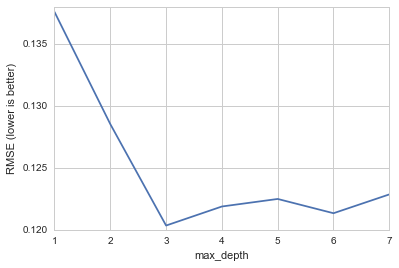

In [60]:
#Find best tree depth
# instantiate a DecisionTreeRegressor (with random_state=1)
from sklearn.tree import DecisionTreeRegressor
# use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model
from sklearn.cross_validation import cross_val_score

# list of values to try
max_depth_range = range(1, 8)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X_train, y_train, cv=14, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
    
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [61]:
#Set tree max_depth=6 (5 has a lower accuracy) to avoid over fitting

dtree = DecisionTreeClassifier(max_depth=6)
dtree.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % dtree.score(X_test, y_test)

Accuracy: 0.981


ROC AUC: 0.986


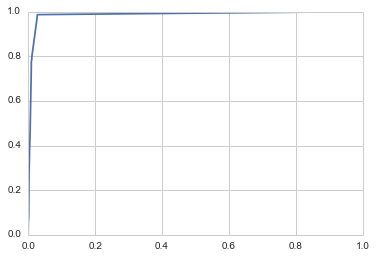

In [62]:
# Plot ROC curve and Evaluate ROC AUC score of model on date set
probas = dtree.predict_proba(X_test)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])

print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1])

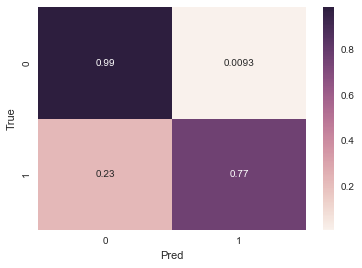

Confusion Matrix:
[[8376   79]
 [  85  285]]


In [63]:
# Get confusion matrix on test set
y_pred = dtree.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

In [64]:
# Precision of the model using test data to predict the contamination is 78%
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      8455
          1       0.78      0.77      0.78       370

avg / total       0.98      0.98      0.98      8825



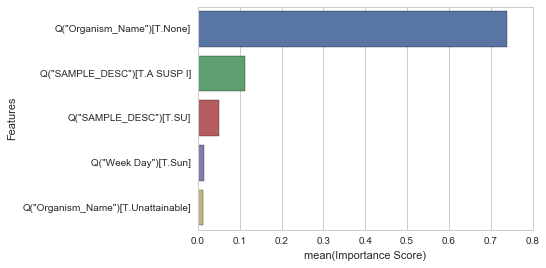

In [65]:
# Plot importances for all features for dtree
features = X.columns
feature_importances = dtree.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

#Plot top 5 only
sns.barplot(y='Features', x='Importance Score', data=features_df.head())

### Try Bagged Decision Trees for Classification

In [66]:
from sklearn.ensemble import BaggingClassifier

cart = DecisionTreeClassifier(max_depth=6)
num_trees = 100
bdtree = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=1)

bdtree.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % bdtree.score(X_test, y_test)

Accuracy: 0.983


ROC AUC: 0.994


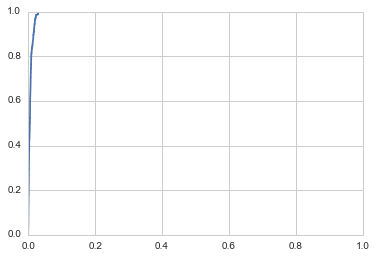

In [67]:
# Plot ROC curve and Evaluate ROC AUC score of model on date set
probas = bdtree.predict_proba(X_test)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])

print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, bdtree.predict_proba(X_test)[:,1])

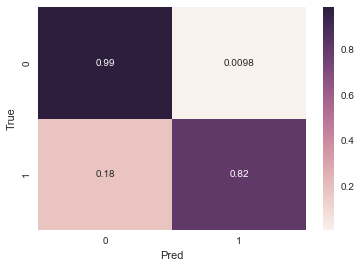

Confusion Matrix:
[[8372   83]
 [  68  302]]


In [68]:
# Get confusion matrix on test set
y_pred = bdtree.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

In [69]:
# Precision of the model using test data to predict the contamination is 78%
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      8455
          1       0.78      0.82      0.80       370

avg / total       0.98      0.98      0.98      8825



## 4. Binary classification using Random Forest
Using the same training and test data as earlier, we'll fit the Random Forest classifier:

### Find the best number of trees n for the random forest using the Grid search

Best Params:
{'n_estimators': 200}
Accuracy using best param: 0.977


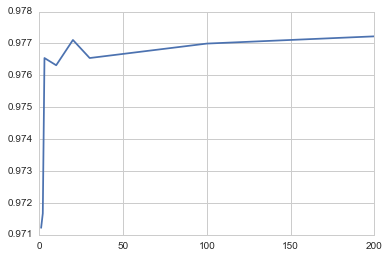

In [70]:
# Random Forest Classification (Random forest is an extension of bagged decision trees.)
# Set list of values to grid search over
n = [1, 2, 3, 10, 20, 30, 100, 200]
params = {'n_estimators': n}

# Perform grid search using list of values
gs = grid_search.GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params)
gs.fit(X_train, y_train)

# Get best value to use
print "Best Params:"
print gs.best_params_
print "Accuracy using best param: %0.3f" % gs.best_score_

# Plot scores
plt.plot(n, [s[1] for s in gs.grid_scores_])

In [71]:
#Use n_estimators=200

rforest = RandomForestClassifier(n_estimators=200, random_state=1)
rforest.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % rforest.score(X_test, y_test)

Accuracy: 0.979


ROC AUC: 0.992


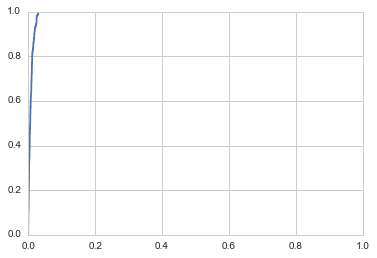

In [72]:
# Plot ROC curve and Evaluate ROC AUC score of model on date set
probas = rforest.predict_proba(X_test)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])

print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, rforest.predict_proba(X_test)[:,1])

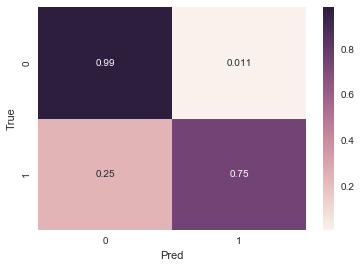

Confusion Matrix:
[[8362   93]
 [  91  279]]


In [73]:
# Get confusion matrix on test set
y_pred = rforest.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

In [74]:
# Precision of the model using test data to predict the contamination is 78%
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      8455
          1       0.75      0.75      0.75       370

avg / total       0.98      0.98      0.98      8825



In [79]:
print "Mean Squared Error is ", metrics.mean_squared_error(y_test, y_pred)

 Mean Squared Error is  0.0208498583569


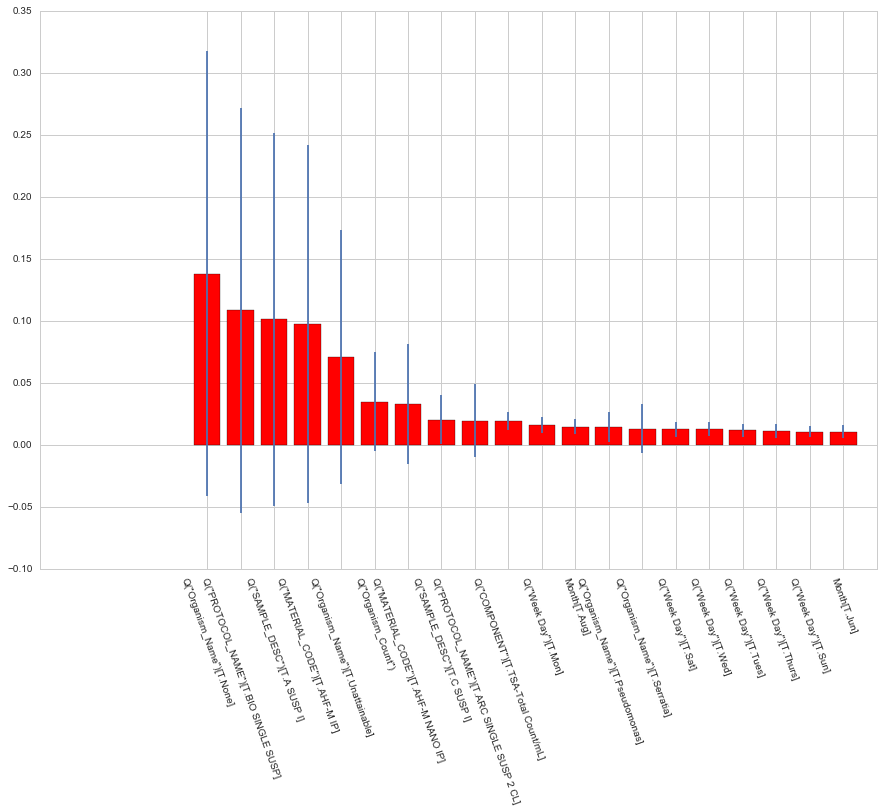

In [90]:
f_importances = rforest.feature_importances_
f_names = X_train
f_std = np.std([tree.feature_importances_ for tree in rforest.estimators_], axis=0)
zz = zip(f_importances, f_names, f_std)
zzs = sorted(zz, key=lambda x: x[0], reverse=True)
imps = [x[0] for x in zzs[:20]]
labels = [x[1] for x in zzs[:20]]
errs = [x[2] for x in zzs[:20]]
plt.subplots(figsize=(15,10))
plt.bar(range(20), imps, color="r", yerr=errs, align="center")
plt.xticks(range(20), labels, rotation=-70);

The output from this gives us a ranked list of feature importance along with error bars for each. Looking at the list, these rankings would seem to make sense with ???.

## 5. Boosting
1. Stochastic Gradient Boosting Regressor

In [134]:
from sklearn.ensemble import GradientBoostingRegressor
regr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, random_state=1)
regr.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % regr.score(X_test, y_test)

Accuracy: 0.959


In [135]:
# Precision of the model using test data to predict the contamination is 78%
y_pred = regr.predict(X_test)
#Couldn't print out cm since y_pred and y_test is not the same type ???

In [133]:
print "Mean Squared Error is ", metrics.mean_squared_error(y_test, regr.predict(X_test))

 Mean Squared Error is  0.00103718427466


2. Stochastic Gradient Boosting Classification

In [98]:
from sklearn.ensemble import GradientBoostingClassifier

gboost = GradientBoostingClassifier(n_estimators=100, random_state=7)

gboost.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % gboost.score(X_test, y_test)

Accuracy: 0.984


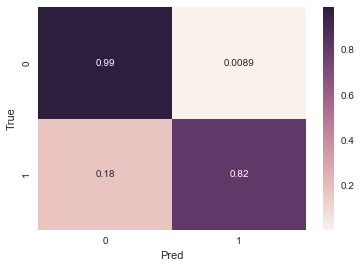

Confusion Matrix:
[[8380   75]
 [  68  302]]


In [99]:
# Get confusion matrix on test set
y_pred = gboost.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

In [100]:
# Precision of the model using test data to predict the contamination is 78%
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      8455
          1       0.80      0.82      0.81       370

avg / total       0.98      0.98      0.98      8825



In [103]:
print "Mean Squared Error is ", metrics.mean_squared_error(y_test, gboost.predict(X_test))

 Mean Squared Error is  0.0162039660057


## Conclusion ???
1. KNN Classifier:

2. Linear Logistic model:
has the difficulty to extract the individual information from logistic regression models, especially ones of this complexity.

3. Decision tree :??

4. Random tree can gives us a ranked list of feature importance along with error bars for each. Looking at the list, these rankings would seem to make sense with ??

